In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision import datasets

In [15]:
class Generator(nn.Module):
    def __init__(self, img_shape, latent_dim):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            *self._block(latent_dim, 128, normalize=False),
            *self._block(128, 256),
            *self._block(256, 512),
            *self._block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def _block(self, in_features, out_features, normalize=True):
        layers = [nn.Linear(in_features, out_features)]
        if normalize:
            layers.append(nn.BatchNorm1d(out_features, 0.8))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *self.img_shape)
        return img


In [16]:
class Critic(nn.Module):
    def __init__(self, img_shape):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, z):
        img_flat = z.view(z.shape[0], -1)
        validity = self.model(img_flat)
        return validity


In [17]:
def weight_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [18]:
def to_img(x):
    x = x.clamp(0, 1)
    return x


In [19]:
class Hyperparameters:
    n_epochs = 70
    batch_size = 64
    lr = 0.00005
    latent_dim = 100
    img_size = 32
    channels = 1
    n_critic = 5
    clip_value = 0.01
    sample_interval = 400

In [20]:
hp = Hyperparameters()

In [21]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [22]:
root_path = "./data"  # Changed to relative path

In [23]:
train_dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        root_path,
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.Resize(hp.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]),
    ),
    batch_size=hp.batch_size,
    shuffle=True,
)

In [24]:
# Initialize models
img_shape = (hp.channels, hp.img_size, hp.img_size)
generator = Generator(img_shape, hp.latent_dim).to(device)
critic = Critic(img_shape).to(device)

# Apply weight initialization
generator.apply(weight_init_normal)
critic.apply(weight_init_normal)

# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=hp.lr)
optimizer_C = torch.optim.RMSprop(critic.parameters(), lr=hp.lr)

In [25]:
def train_wgan(generator, critic, train_dataloader, hp, device):
    """
    WGAN training with weight clipping.

    Key principles:
    1. Critic loss: -E[D(real)] + E[D(fake)] (Wasserstein distance)
    2. Generator loss: -E[D(fake)]
    3. Clip critic weights to [-c, c] after each update
    4. Train critic n_critic times per generator update
    """

    generator.train()
    critic.train()

    for epoch in range(hp.n_epochs):
        for i, (real_imgs, _) in enumerate(train_dataloader):

            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            for _ in range(hp.n_critic):
                optimizer_C.zero_grad()

                # Generate fake images
                z = torch.randn(batch_size, hp.latent_dim).to(device)  # Fixed shape
                fake_imgs = generator(z).detach()

                # Critic loss: Wasserstein distance
                critic_real = critic(real_imgs).mean()
                critic_fake = critic(fake_imgs).mean()
                critic_loss = -critic_real + critic_fake

                critic_loss.backward()
                optimizer_C.step()

                # Weight clipping for Lipschitz constraint
                for p in critic.parameters():
                    p.data.clamp_(-hp.clip_value, hp.clip_value)


            optimizer_G.zero_grad()

            # Generate new fake images
            z = torch.randn(batch_size, hp.latent_dim).to(device)  # Fixed shape
            fake_imgs = generator(z)

            # Generator loss
            gen_loss = -critic(fake_imgs).mean()

            gen_loss.backward()
            optimizer_G.step()

            batches_done = epoch * len(train_dataloader) + i

            if batches_done % hp.sample_interval == 0:
                print(f"[Epoch {epoch}/{hp.n_epochs}] "
                      f"[Batch {i}/{len(train_dataloader)}] "
                      f"[D loss: {critic_loss.item():.4f}] "
                      f"[G loss: {gen_loss.item():.4f}]")

In [26]:
if __name__ == "__main__":
    print("Starting WGAN training...")
    train_wgan(generator, critic, train_dataloader, hp, device)
    print("Training complete!")

    # Save models
    torch.save(generator.state_dict(), 'wgan_generator.pth')
    torch.save(critic.state_dict(), 'wgan_critic.pth')
    print("Models saved!")

Starting WGAN training...
[Epoch 0/70] [Batch 0/938] [D loss: -0.0781] [G loss: 0.0101]
[Epoch 0/70] [Batch 400/938] [D loss: -2.2044] [G loss: -1.3602]
[Epoch 0/70] [Batch 800/938] [D loss: -0.5006] [G loss: 0.0448]
[Epoch 1/70] [Batch 262/938] [D loss: -0.6177] [G loss: -0.4035]
[Epoch 1/70] [Batch 662/938] [D loss: -0.6743] [G loss: -0.5013]
[Epoch 2/70] [Batch 124/938] [D loss: -0.4949] [G loss: -0.9867]
[Epoch 2/70] [Batch 524/938] [D loss: -0.3217] [G loss: -0.5734]
[Epoch 2/70] [Batch 924/938] [D loss: -0.3498] [G loss: -0.6564]
[Epoch 3/70] [Batch 386/938] [D loss: -0.3201] [G loss: -0.8792]
[Epoch 3/70] [Batch 786/938] [D loss: -0.4359] [G loss: -0.0231]
[Epoch 4/70] [Batch 248/938] [D loss: -0.3578] [G loss: -0.8756]
[Epoch 4/70] [Batch 648/938] [D loss: -0.4734] [G loss: -0.0857]
[Epoch 5/70] [Batch 110/938] [D loss: -0.3538] [G loss: -0.7768]
[Epoch 5/70] [Batch 510/938] [D loss: -0.4895] [G loss: -0.5423]
[Epoch 5/70] [Batch 910/938] [D loss: -0.3852] [G loss: -0.6090]
[Ep

### Need More Training But GPU .........

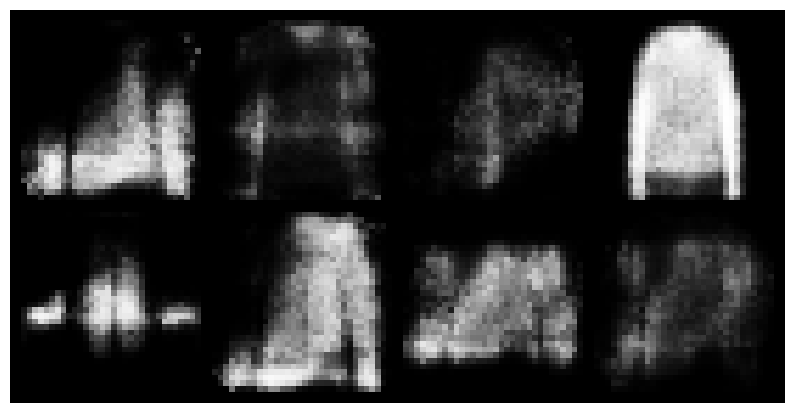

In [27]:
# Prediction:
# img = torch.tensor(np.rand.random(8,3,64,64)) # Original incorrect line
# Generate random noise as input to the generator
z = torch.randn(8, hp.latent_dim).to(device)

# Load the trained generator
generator.load_state_dict(torch.load('wgan_generator.pth'))
generator.eval() # Set the generator to evaluation mode

# Generate fake images
with torch.no_grad(): # Disable gradient calculation for inference
    fake_images = generator(z).detach().cpu()

# Display the generated images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Denormalize the images
fake_images = fake_images * 0.5 + 0.5

# Make a grid of images
grid = make_grid(fake_images, nrow=4, normalize=True)

# Plot the grid
plt.figure(figsize=(10,10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [27]:
#